In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit
from scipy import stats

from copy import copy

import matplotlib
pgf_with_latex = {
		"pgf.texsystem": "pdflatex",
		"text.usetex": True,			# use LaTeX to write all text
		"font.family": "sans-serif",		
		"font.sans-serif": "Helvetica",
		"font.size": 25,				# default font size
		"axes.titlepad": 20,			# x and y label size
		"axes.labelsize": 24,			# x and y label size
		"axes.titlesize": 24,		  # subfigure title size, i.e. title size when one figure
		"legend.fontsize": 22,			# legend size
		"xtick.labelsize": 23,			# x axis tick label size
		"ytick.labelsize": 23,			# y axis tick label 
		"figure.titlesize": 25,         # Figure title size, useful when you have multiple plots in one canvas.
		"pgf.preamble": r"\usepackage{xcolor}",     # xcolor for colours
		"figure.autolayout": False
}
matplotlib.rcParams.update(pgf_with_latex)
import matplotlib.patches as patches 
import matplotlib.image as mpimg

## Constant

In [18]:
hbarc = 0.1973269631 #GeV fm
hbarc2 = hbarc*hbarc #GeV^2 fm^2
# 1 fm = 10^(-15) m, 1 barn = 10**(-28) m^2, 1 nb = 10^(-28-9) m^2 = 10**(-30-7) m^2 = 10^(-7) fm^2
hbarc2_nb = hbarc2* 10**7
mp = 0.938272081
mHe4 = 3.7273794066
mJpsi = 3.09600

## Utils

In [19]:

def qgamma(W, Q2, M = mHe4, Mv = mJpsi):
    return 1/2/W*np.sqrt(W**4 - 2* (-Q2 + M**2)*W**2 + (-Q2 - M**2)**2)

def qvector(W, M = mHe4, Mv = mJpsi):
    return 1/2/W*np.sqrt(W**4 - 2 *(Mv**2 + M**2)*W**2 + (Mv**2 - M**2)**2)

def Egamma(W, Q2, M = mHe4, Mv = mJpsi):
    return np.sqrt(-Q2 + qgamma(W,Q2, M = M, Mv = Mv)**2)

def Evector(W, M = mHe4, Mv = mJpsi):
    return np.sqrt(Mv**2 + qvector(W, M = M, Mv = Mv)**2)

def t(W, Q2, theta, M = mHe4, Mv = mJpsi):
    return -(-Q2 + Mv**2 - 2*Egamma(W,Q2, M = M, Mv = Mv)*Evector(W, M = M, Mv = Mv) + 2 * qgamma(W, Q2, M = M, Mv = Mv) * qvector(W, M = M, Mv = Mv) * np.cos(theta))

def tmin(W,Q2, M = mHe4, Mv = mJpsi):
    return t(W, Q2, 0, M = M, Mv = Mv)

def tmax(W, Q2, M = mHe4, Mv = mJpsi):
    return t(W, Q2, np.pi, M = M, Mv = Mv)

def Egamma_photo(W, M = mHe4, Mv = mJpsi):
    return (W**2 - M**2)/2/M

def W(Egamma, M= mHe4, Mv = mJpsi):
    return np.sqrt(2*M*Egamma + M**2)

In [20]:
#Code block from S. Prasad
#proton
m_A = 1.575
C_0 = -0.45
m_C = 1.12
mp = 0.938
mJpsi = 3.097
M = mp
#https://arxiv.org/pdf/1910.04707.pdf
def holographic_model(s, t, m_A, C_0, m_C):
    A0=0.414
    x = t
    const_h = 1 / (64* np.pi * (s - M ** 2) ** 2 * 4  * M ** 2)
    c2 = 7.768#5.93#7.0 #6.0 #7.768
    # mS=1
    eta = mJpsi ** 2 / (2 * (s - M ** 2) - mJpsi ** 2 - x)
    # print(eta)
    Ak = A0 * np.power((1 + x / (m_A ** 2)), -3)
    Ck=C_0*np.power((1 + x / (m_C**2)), -3)
    #Ck = (C_0) * (
    #    (1 + (x / 4) * (1 / m_C ** 2 + 1 / m_A ** 2))
    #    / ((1 + x / m_A ** 2) ** 2 * (1 + x / m_C ** 2) ** 2)
    #)
    # return c2*np.power((1+x/(m*m)),-4)*F(s,-x,mJpsi,M)*(2*x+8*M**2)
    return Ak, Ck, (
        c2 ** 2
        * const_h
        * (Ak ** 2 + 2 * eta ** 2 * Ak * 4 * Ck + eta ** 4 * (4 * Ck) ** 2)
        / A0 ** 2
        * F(s, -x, mJpsi, mp)
        * (2 * x + 8 * M ** 2)
    )

def F(s, t, M, m):
    return (1 / (4096 * M ** 2)) * (
        -9 * M ** 10
        + M ** 8 * (-32 + 68 * m ** 2 + 28 * s + 37 * t)
        + 2
        * M ** 6
        * (256 * m ** 4 + 8 * m ** 2 * (32 * s - 3 * t) + t * (56 - 40 * s - 29 * t))
        + 2
        * M ** 4
        * (
            -136 * m ** 6
            + 64 * s ** 2
            - 56 * s ** 3
            + 8 * m ** 4 * (8 + 27 * s - 64 * t)
            + 3 * t ** 2 * (-24 + 7 * t)
            + 4 * s * t * (-4 + 9 * t)
            - 4 * m ** 2 * (6 * s ** 2 + 32 * s * (1 + 4 * t) + t * (-4 + 25 * t))
        )
        + M ** 2
        * (
            144 * m ** 8
            + 144 * s ** 4
            - 192 * s ** 2 * t
            + 96 * s ** 3 * t
            - 16 * s * (-4 + t) * t ** 2
            + (80 - 13 * t) * t ** 3
            + 96 * m ** 6 * (-6 * s + 7 * t)
            + 32 * m ** 4 * (27 * s ** 2 - 6 * t - 39 * s * t + 8 * t ** 2)
            + 16
            * m ** 2
            * (
                -36 * s ** 3
                + 30 * s ** 2 * t
                + 24 * s * t * (1 + 2 * t)
                + t ** 2 * (-4 + 17 * t)
            )
        )
        - t
        * (2 * m ** 2 - 2 * s - t)
        * (
            64 * m ** 4
            + 8 * m ** 6
            - 8 * s ** 3
            + 76 * m ** 4 * t
            - 16 * t ** 2
            - 90 * m ** 2 * t ** 2
            + t ** 3
            + 4 * s ** 2 * (16 + 6 * m ** 2 + 3 * t)
            - 2 * s * (12 * m ** 4 + 3 * t ** 2 + m ** 2 * (64 + 44 * t))
        )
    )

def gpd_based_model(x, s, A, C):
    const1_unitconv=70.231;
    xi = (-x - mJpsi**2)/(2*M**2+mJpsi**2 - 2*s +x);
    A_conf=1.0; #0.8; #5/4
    H2= A + 4* xi**2 *C
    E2= -xi**2 *C*4
    const_2=1/pow(s-M*M,2);
    myfit =const1_unitconv*const_2*(4 /pow(xi, 4))*((1 + x / (4 * M * M)) * E2 *E2 - 2 * E2 * (H2 + E2) + (1 - xi * xi) * (H2 + E2) *(H2+E2));
    return myfit

# def gpd_based_model(x, y, *par):
#     A0=0.58;
#     M=0.938;
#     Mj=3.097;
#     Q=0.0;
#     const1_unitconv=70.231;
#     s=M*M-Q*Q+2*M*y;
#     q_gamma = (1/(2*pow(s,0.5)))*pow(s*s-2*(-Q*Q+M*M)*s+(-Q*Q-M*M)*(-Q*Q-M*M),0.5);
#     q_jpsi = (1/(2*pow(s,0.5)))*pow(s*s-2*(Mj*Mj+M*M)*s+(Mj*Mj-M*M)*(Mj*Mj-M*M),0.5);
#     E_jpsi = pow(Mj*Mj+q_jpsi*q_jpsi,0.5);
#     E_gamma = pow(-Q*Q+q_gamma*q_gamma,0.5);
#     P_z = (s-M*M)/(2*pow(s,0.5));
#     P_0 = pow(P_z*P_z+M*M,0.5);
#     P_plus = (P_0+P_z)/(pow(2,0.5));
#     P_prime_z = -(x+Mj*Mj-2*E_gamma*E_jpsi)/(2*q_gamma);
#     K=q_jpsi;
#     P_prime_0=pow((-K)*(-K)+M*M,0.5);
#     P_prime_plus=(P_prime_0+P_prime_z)/pow(2,0.5);
#     xi = (P_plus-P_prime_plus)/(P_plus+P_prime_plus);
#     A_conf=1.0; #0.8; #5/4
#     # dipole-dipole
#     #H2=A0/pow((1+x/(par[0]*par[0])),2)+pow(2*xi,2)*par[1]/pow((1+x/(par[2]*par[2])),2);
#     #E2=-pow(2*xi,2)*par[1]/pow((1+x/(par[2]*par[2])),2);
#     #tripole-tripole
#     H2=A0/(A_conf*pow((1+x/(par[0]*par[0])),3))+pow(2*xi,2)*par[1]/(A_conf*pow((1+x/(par[2]*par[2])),3));
#     E2=-pow(2*xi,2)*par[1]/(A_conf*pow((1+x/(par[2]*par[2])),3));
#     #dipole-tripole
#     #H2=A0/pow((1+x/(par[0]*par[0])),3)+pow(2*xi,2)*par[1]/pow((1+x/(par[2]*par[2])),3);
#     #E2=-pow(2*xi,2)*par[1]/pow((1+x/(par[2]*par[2])),3);
#     const_2=1/pow(s-M*M,2);
#     myfit =const1_unitconv*const_2*(4 /pow(xi, 4))*((1 + x / (4 * M * M)) * E2 *E2 - 2 * E2 * (H2 + E2) + (1 - xi * xi) * (H2 + E2) *(H2+E2));
#     return myfit

## Fit function

In [21]:
def laurent_series(x, *par, c=1, n_start=-6, n_end=0):
    sequences = []
    sequences_zero = []
    j = 0
    for i in range(n_start, n_end+1):
        sequences.append(list(par)[j] * (x+c)**(i))
        sequences_zero.append(list(par)[j]*(0+c)**(i))
        j = j+1
    return np.sum(sequences, axis = 0)/np.sum(sequences_zero, axis = 0)

## Collecting Data

In [53]:
q2_stanford_fm2 = [0.5, 1, 1.5, 2, 3, 4, 5, 6, 7, 8.0, 8.1, 8.5, 9, 9.5, 10, 10.5, 11, 12, 13.5, 15, 16, 18, 20]
q2_stanford_gev = hbarc2*np.array(q2_stanford_fm2)
fc_stanford = [0.796, 0.626, 0.494, 0.391, 0.225, 0.1585, 0.0965, 0.0595, 0.0319, 0.0184, 0.0175, 0.0118, 0.0069, 0.0055, 0.0031, 0.0023, 0.0043, 0.0078, 0.0094, 0.0089, 0.0098, 0.0082, 0.0070]
fc_uncup_stanford = [0.025, 0.030, 0.015, 0.012, 0.008, 0.0050, 0.0030, 0.0030, 0.0014, 0.0011, 0.0011, 0.0011, 0.0015, 0.0011, 0.0009, 0.0012, 0.0007, 0.0011, 0.0008, 0.0011, 0.0008, 0.0008, 0.0009]
fc_uncdown_stanford = copy(fc_uncup_stanford)
fc_uncdown_stanford[-9] = 0.0019
fc_uncdown_stanford[-8] = 0.0023
fc_squared_stanford  = np.array(fc_stanford)**2
fc_squared_uncup_stanford = (np.array(fc_stanford)+np.array(fc_uncup_stanford))**2 - fc_squared_stanford
fc_squared_uncdown_stanford = -(np.array(fc_stanford)-np.array(fc_uncdown_stanford))**2 + fc_squared_stanford

df_stanford = pd.DataFrame({"Q2": q2_stanford_gev, "Fc": fc_stanford,
                            "Fc_uncup": fc_uncup_stanford, "Fc_uncdown": fc_uncdown_stanford,
                            "Fc_squared": fc_squared_stanford,
                            "Fc_squared_uncup": fc_squared_uncup_stanford, "Fc_squared_uncdown": fc_squared_uncdown_stanford})
df_stanford.loc[:, "experiment"] = "Stanford"

q2_stanford2_fm2 = [0.348, 0.401, 0.452, 0.502, 0.544, 0.603, 0.642, 0.704, 0.747, 0.805, 0.856, 0.907, 1.005, 1.009, 1.107, 1.110, 1.208, 1.212, 1.315, 1.417, 1.511, 1.519, 1.622, 1.725, 1.817, 2.015, 2.020, 2.224, 2.521, 2.53, 2.55, 2.65, 2.76, 2.87, 3.03, 3.05, 3.08, 3.54, 3.85, 4.06, 4.11, 4.32, 4.64, 5.06, 6.08, 6.13, 6.22]
q2_stanford2_gev = hbarc2*np.array(q2_stanford2_fm2)
fc_squared_stanford2 = [7.21*10**(-1), 6.87*10**(-1), 6.53*10**(-1), 6.29*10**(-1), 6.09*10**(-1), 5.76*10**(-1), 5.50*10**(-1), 5.23*10**(-1), 4.91*10**(-1), 4.74*10**(-1), 4.51*10**(-1), 4.30*10**(-1), 4.02*10**(-1), 3.91*10**(-1), 3.69*10**(-1), 3.56*10**(-1), 3.34*10**(-1), 3.28*10**(-1), 2.92*10**(-1), 2.68*10**(-1), 2.52*10**(-1), 2.45*10**(-1), 2.26*10**(-1), 2.05*10**(-1), 1.88*10**(-1), 1.56*10**(-1), 1.59*10**(-1), 1.32*10**(-1), 1.01*10**(-1), 9.85*10**(-2), 9.67*10**(-2), 8.83*10**(-2), 8.18*10**(-2), 7.34*10**(-2), 6.22*10**(-2), 6.28*10**(-2), 5.99*10**(-2), 3.86*10**(-2), 2.93*10**(-2), 2.48*10**(-2), 2.30*10**(-2), 1.91*10**(-2), 1.40*10**(-2), 9.87*10**(-3), 3.59*10**(-3), 3.22*10**(-3), 2.78*10**(-3)]
fc_squared_uncup_stanford2 = [0.18*10**(-1), 0.10*10**(-1), 0.12*10**(-1), 0.12*10**(-1), 0.15*10**(-1), 0.10*10**(-1), 0.14*10**(-1), 0.09*10**(-1), 0.12*10**(-1), 0.09*10**(-1), 0.11*10**(-1), 0.08*10**(-1), 0.08*10**(-1), 0.10*10**(-1), 0.08*10**(-1), 0.09*10**(-1), 0.07*10**(-1), 0.06*10**(-1), 0.07*10**(-1), 0.07*10**(-1), 0.04*10**(-1), 0.06*10**(-1), 0.06*10**(-1), 0.05*10**(-1), 0.04*10**(-1), 0.04*10**(-1), 0.03*10**(-1), 0.02*10**(-1), 0.03*10**(-1), 0.19*10**(-2), 0.24*10**(-2), 0.22*10**(-2), 0.20*10**(-2), 0.18*10**(-2), 0.10*10**(-2), 0.12*10**(-2), 0.15*10**(-2), 0.08*10**(-2), 0.07*10**(-2), 0.05*10**(-2), 0.06*10**(-2), 0.05*10**(-2), 0.03*10**(-2), 0.25*10**(-3), 0.07*10**(-3), 0.11*10**(-3), 0.14*10**(-3)]
fc_squared_uncdown_stanford2 = copy(fc_squared_uncup_stanford2)
fc_stanford2 = np.sqrt(fc_squared_stanford2)
fc_uncup_stanford2 = np.sqrt(np.array(fc_squared_stanford2)+np.array(fc_squared_uncup_stanford2)) - fc_stanford2
fc_uncdown_stanford2 = -np.sqrt(np.array(fc_squared_stanford2)-np.array(fc_squared_uncdown_stanford2)) + fc_stanford2

df_stanford2 = pd.DataFrame({"Q2": q2_stanford2_gev, "Fc": fc_stanford2,
                            "Fc_uncup": fc_uncup_stanford2, "Fc_uncdown": fc_uncdown_stanford2,
                            "Fc_squared": fc_squared_stanford2,
                            "Fc_squared_uncup": fc_squared_uncup_stanford2, "Fc_squared_uncdown": fc_squared_uncdown_stanford2})
df_stanford2.loc[:, "experiment"] = "Stanford"

q2_orsay_fm2 = [2.52, 3.025, 3.53, 4.034, 4.54, 5.044, 5.544, 6.05, 6.56, 7.05, 7.57, 8.07]
q2_orsay_gev = hbarc2*np.array(q2_orsay_fm2)
fc_squared_orsay = [0.130, 0.0815, 0.0500, 0.0318, 0.0206, 0.0122, 0.00825, 0.00464, 0.00220, 0.00134, 0.00085, 0.000266]
fc_squared_uncup_orsay = [0.0033, 0.0028, 0.0018, 0.00093, 0.0006, 0.00045, 0.00042, 0.00027, 0.00015, 0.000094, 0.00015, 0.000042]
fc_squared_uncdown_orsay = fc_squared_uncup_orsay
fc_orsay = np.sqrt(fc_squared_orsay)
fc_uncup_orsay = np.sqrt(np.array(fc_squared_orsay)+np.array(fc_squared_uncup_orsay)) - fc_orsay
fc_uncdown_orsay = -np.sqrt(np.array(fc_squared_orsay)-np.array(fc_squared_uncdown_orsay)) + fc_orsay

df_orsay = pd.DataFrame({"Q2": q2_orsay_gev, "Fc": fc_orsay,
                            "Fc_uncup": fc_uncup_orsay, "Fc_uncdown": fc_uncdown_orsay,
                            "Fc_squared": fc_squared_orsay,
                            "Fc_squared_uncup": fc_squared_uncup_orsay, "Fc_squared_uncdown": fc_squared_uncdown_orsay})
df_orsay.loc[:, "experiment"] = "Orsay"

q2_slac_gev = [0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.4]
fc_slac = [5.49, 2.65, 1.36, 0.579, 0.278, 0.065, 0.043]
fc_slac = 10**(-3)*np.array(fc_slac)
fc_uncup_slac = [0.60, 0.24, 0.19, 0.098, 0.068, 0.025, 0]
fc_uncdown_slac = copy(fc_uncup_slac)
fc_uncdown_slac[-1] = 0.043
fc_squared_slac  = np.array(fc_slac)**2
fc_squared_uncup_slac = (np.array(fc_slac)+np.array(fc_uncup_slac))**2 - fc_squared_slac
fc_squared_uncdown_slac = -(np.array(fc_slac)-np.array(fc_uncdown_slac))**2 + fc_squared_slac

df_slac = pd.DataFrame({"Q2": q2_slac_gev, "Fc": fc_slac,
                            "Fc_uncup": fc_uncup_slac, "Fc_uncdown": fc_uncdown_slac,
                            "Fc_squared": fc_squared_slac,
                            "Fc_squared_uncup": fc_squared_uncup_slac, "Fc_squared_uncdown": fc_squared_uncdown_slac})
df_slac.loc[:, "experiment"] = "SLAC"

q2_mainz_fm2 = [0.261, 0.416, 0.419, 0.477, 0.560, 0.596, 0.717, 0.723, 0.837, 0.900, 0.902, 0.952, 1.059, 1.095, 1.200, 1.205, 1.500, 1.500, 1.500, 1.501, 1.746, 1.800, 1.800, 1.800, 1.980, 2.161, 2.500, 2.500, 2.500, 2.890, 3.300, 3.661, 4.000]
q2_mainz_gev = hbarc2*np.array(q2_mainz_fm2)
fc_mainz = [0.8856, 0.8223, 0.8216, 0.8016, 0.7705, 0.7554, 0.7188, 0.7134, 0.6780, 0.6589, 0.6564, 0.6420, 0.6108, 0.5994, 0.5742, 0.5732, 0.4979, 0.4997, 0.4997, 0.4994, 0.4447, 0.4363, 0.4345, 0.4377, 0.4024, 0.3701, 0.3183, 0.3165, 0.3175, 0.2670, 0.2225, 0.1875, 0.1609]
fc_uncup_mainz =  [1.15, 1.13, 1.14, 1.00, 1.00, 1.00, 1.02, 0.96, 1.15, 0.98, 1.06, 1.06, 1.19, 1.32, 0.96, 0.94, 0.90, 0.94, 0.87, 0.88, 1.20, 0.99, 1.02, 0.97, 1.11, 1.03, 1.44, 1.04, 0.99, 1.11, 1.25, 1.27, 1.45]
fc_uncup_mainz = np.array(fc_uncup_mainz)*0.01*fc_mainz
fc_uncdown_mainz = copy(fc_uncup_mainz)
fc_squared_mainz  = np.array(fc_mainz)**2
fc_squared_uncup_mainz = (np.array(fc_mainz)+np.array(fc_uncup_mainz))**2 - fc_squared_mainz
fc_squared_uncdown_mainz = -(np.array(fc_mainz)-np.array(fc_uncdown_mainz))**2 + fc_squared_mainz
df_mainz = pd.DataFrame({"Q2": q2_mainz_gev, "Fc": fc_mainz,
                            "Fc_uncup": fc_uncup_mainz, "Fc_uncdown": fc_uncdown_mainz,
                            "Fc_squared": fc_squared_mainz,
                            "Fc_squared_uncup": fc_squared_uncup_mainz, "Fc_squared_uncdown": fc_squared_uncdown_mainz})
df_mainz.loc[:, "experiment"] = "Mainz"

q2_jlab_fm2 = [28.9, 33.6, 38.9, 44.4, 49.4, 54.7, 63.2, 68.5, 77.0]
q2_jlab_gev = hbarc2*np.array(q2_jlab_fm2)
fc_jlab = [1.55* 10**(-3), 5.77* 10**(-4), 2.01* 10**(-4), 8.01* 10**(-5), 1.36* 10**(-5), 1.42* 10**(-5), 2.02* 10**(-5), 2.26* 10**(-5), 8.67* 10**(-6)]
fc_uncup_jlab = [0.07* 10**(-3), 0.32* 10**(-4), 0.23* 10**(-4), 0.12* 10**(-5), 0.32* 10**(-5), 0.33* 10**(-5), 0.68* 10**(-5), 0.76* 10**(-5), 4.43* 10**(-6)]
fc_uncdown_jlab = fc_uncup_jlab
fc_squared_jlab  = np.array(fc_jlab)**2
fc_squared_uncup_jlab = (np.array(fc_jlab)+np.array(fc_uncup_jlab))**2 - fc_squared_jlab
fc_squared_uncdown_jlab = -(np.array(fc_jlab)-np.array(fc_uncdown_jlab))**2 + fc_squared_jlab
df_jlab = pd.DataFrame({"Q2": q2_jlab_gev, "Fc": fc_jlab,
                            "Fc_uncup": fc_uncup_jlab, "Fc_uncdown": fc_uncdown_jlab,
                            "Fc_squared": fc_squared_jlab,
                            "Fc_squared_uncup": fc_squared_uncup_jlab, "Fc_squared_uncdown": fc_squared_uncdown_jlab})
df_jlab.loc[:, "experiment"] = "JLab Hall A"

In [54]:
df_he4fc = pd.concat([df_stanford, df_stanford2, df_orsay, df_mainz, df_jlab])

In [55]:
df_he4fc = df_he4fc.sort_values(by = 'Q2')

In [56]:
# df_he4fc = df_he4fc.loc[df_he4fc.Q2<2, :]
first_diff_min = 0.4
df_he4fc.loc[(df_he4fc.Q2>first_diff_min) & (df_he4fc.Q2<2), "Fc"] = -df_he4fc.loc[(df_he4fc.Q2>first_diff_min) & (df_he4fc.Q2<2), "Fc"]
Fc_uncup, Fc_uncdown = df_he4fc.loc[(df_he4fc.Q2>first_diff_min) & (df_he4fc.Q2<2), ["Fc_uncup", "Fc_uncdown"]].to_numpy().T
df_he4fc.loc[(df_he4fc.Q2>first_diff_min) & (df_he4fc.Q2<2), "Fc_uncup"] = Fc_uncdown
df_he4fc.loc[(df_he4fc.Q2>first_diff_min) & (df_he4fc.Q2<2), "Fc_uncdown"] = Fc_uncup

453.06541788796704 115 0.0


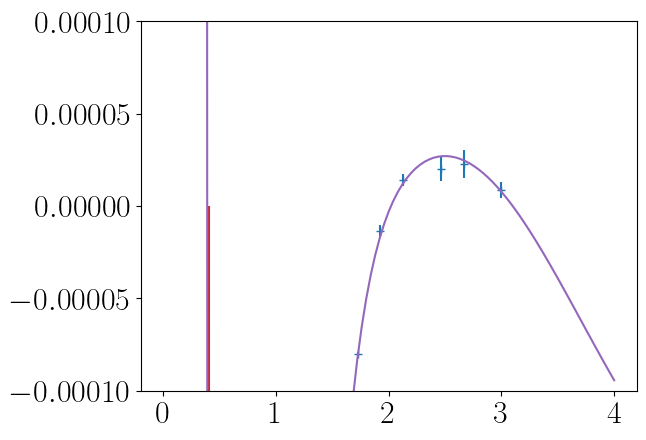

In [59]:
# plt.errorbar(q2_stanford_gev, fc_stanford, ls = '', marker = 'o')
# plt.errorbar(q2_stanford2_gev, np.sqrt(fc_squared_stanford2), ls = '', marker = 'o')
# plt.errorbar(q2_slac_gev, abs_fc_slac, ls = '', marker = 'o')

# plt.errorbar(q2_orsay_gev, np.sqrt(fcsquared_orsay), ls = '', marker = 'o')
# plt.errorbar(q2_mainz_gev, fc_mainz, ls = '', marker = 'o')
# plt.errorbar(q2_jlab_gev, fc_jlab_abs, ls = '', marker = 'o')

for experiment in np.unique(df_he4fc.experiment):
    plt.errorbar(df_he4fc.loc[df_he4fc.experiment==experiment].Q2, df_he4fc.loc[df_he4fc.experiment==experiment].Fc, yerr= [df_he4fc.loc[df_he4fc.experiment==experiment].Fc_uncdown, df_he4fc.loc[df_he4fc.experiment==experiment].Fc_uncup], ls ='', marker = '+', label = experiment)
# plt.yscale('log')
# p = np.poly1d(np.polyfit(1/(df_he4fc.Q2+c), df_he4fc.Fc, deg = 2))
min_score = 1000000
min_popt = 0
min_c = 0
min_n_start = 0
min_n_end = 0
for trial in range(1):
    c = np.random.uniform(0.7465, 0.7475)#np.random.uniform(0.1, 3)
    n_start = -8#np.random.randint(-10, -7)
    n_end = 0#np.random.randint(0, 3)
    
    def laurent_series_c_nstart_nend(x, *par):
        return laurent_series(x, *par, c = c, n_start = n_start, n_end = n_end)
    p0 = np.ones(n_end - n_start + 1)
    try:
        popt, pcov = curve_fit(laurent_series_c_nstart_nend, df_he4fc.Q2, df_he4fc.Fc, sigma = (df_he4fc.Fc_uncup + df_he4fc.Fc_uncdown)/2., p0 = p0)
    
        chi2 = np.sum( (df_he4fc.Fc - laurent_series_c_nstart_nend(df_he4fc.Q2, *popt))**2/ ((df_he4fc.Fc_uncup + df_he4fc.Fc_uncdown)/2.)**2)
        dof   = len(df_he4fc) - (n_end - n_start +1)
        score = chi2/dof
        if score < min_score:
            min_score = score
            min_popt = popt
            min_c = c
            min_n_start = n_start
            min_n_end = n_end
    except:
        continue

c = min_c
n_start = min_n_start
n_end   = min_n_end
def laurent_series_c_nstart_nend(x, *par):
    return laurent_series(x, *par, c = c, n_start = n_start, n_end = n_end)
x = np.linspace(0, 4, 101)
plt.errorbar(x, laurent_series_c_nstart_nend(x, *min_popt))
# plt.figlegend()
print(chi2, dof, 1 - stats.chi2.cdf(chi2, dof))

plt.ylim([-0.0001, 0.0001])
plt.show()

453.261922406949 115 0.0


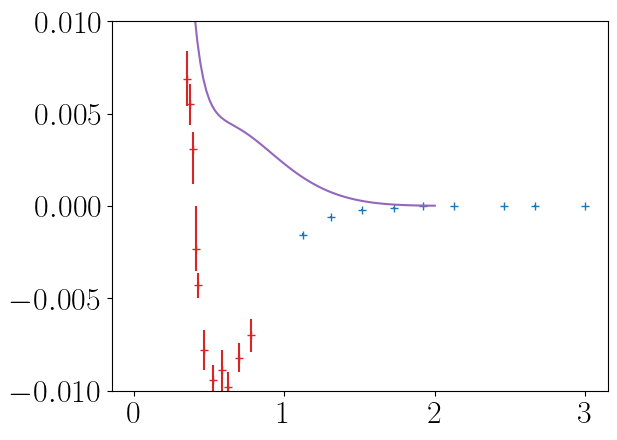

In [60]:
# plt.errorbar(q2_stanford_gev, fc_stanford, ls = '', marker = 'o')
# plt.errorbar(q2_stanford2_gev, np.sqrt(fc_squared_stanford2), ls = '', marker = 'o')
# plt.errorbar(q2_slac_gev, abs_fc_slac, ls = '', marker = 'o')

# plt.errorbar(q2_orsay_gev, np.sqrt(fcsquared_orsay), ls = '', marker = 'o')
# plt.errorbar(q2_mainz_gev, fc_mainz, ls = '', marker = 'o')
# plt.errorbar(q2_jlab_gev, fc_jlab_abs, ls = '', marker = 'o')

for experiment in np.unique(df_he4fc.experiment):
    plt.errorbar(df_he4fc.loc[df_he4fc.experiment==experiment].Q2, df_he4fc.loc[df_he4fc.experiment==experiment].Fc, yerr= [df_he4fc.loc[df_he4fc.experiment==experiment].Fc_uncdown, df_he4fc.loc[df_he4fc.experiment==experiment].Fc_uncup], ls ='', marker = '+', label = experiment)
# plt.yscale('log')
# p = np.poly1d(np.polyfit(1/(df_he4fc.Q2+c), df_he4fc.Fc, deg = 2))
min_score = 1000000
min_popt = 0
min_c = 0
min_n_start = 0
min_n_end = 0
for trial in range(1):
    c = np.random.uniform(0.7465, 0.7475)#np.random.uniform(0.1, 3)
    n_start = -8#np.random.randint(-10, -7)
    n_end = 0#np.random.randint(0, 3)
    
    def laurent_series_c_nstart_nend(x, *par):
        return laurent_series(x, *par, c = c, n_start = n_start, n_end = n_end)
    p0 = np.ones(n_end - n_start + 1)
    try:
        popt2, pcov = curve_fit(laurent_series_c_nstart_nend, df_he4fc.loc[(df_he4fc.Q2>0.55) | (df_he4fc.Q2<0.3)].Q2, np.abs(df_he4fc.loc[(df_he4fc.Q2>0.55) | (df_he4fc.Q2<0.3)].Fc), sigma = (df_he4fc.loc[(df_he4fc.Q2>0.55) | (df_he4fc.Q2<0.3)].Fc_uncup + df_he4fc.loc[(df_he4fc.Q2>0.55) | (df_he4fc.Q2<0.3)].Fc_uncdown)/2., p0 = p0)
    
        chi2 = np.sum( (df_he4fc.Fc - laurent_series_c_nstart_nend(df_he4fc.Q2, *popt))**2/ ((df_he4fc.Fc_uncup + df_he4fc.Fc_uncdown)/2.)**2)
        dof   = len(df_he4fc) - (n_end - n_start +1)
        score = chi2/dof
        if score < min_score:
            min_score = score
            min_popt = popt
            min_c = c
            min_n_start = n_start
            min_n_end = n_endert
    except:
        continue

c = min_c
n_start = min_n_start
n_end   = min_n_end
def laurent_series_c_nstart_nend(x, *par):
    return laurent_series(x, *par, c = c, n_start = n_start, n_end = n_end)
x = np.linspace(0, 2, 101)
plt.errorbar(x, laurent_series_c_nstart_nend(x, *popt2))
# plt.figlegend()
print(chi2, dof, 1 - stats.chi2.cdf(chi2, dof))

plt.ylim([-0.01, 0.01])
plt.show()

In [45]:
popt2

array([  26.68945857, -175.99393449,  488.63392996, -712.66609543,
        593.59983341, -290.42187   ,   82.31292165,  -12.48977733,
          0.7843959 ])

In [89]:
['{:.6e}'.format(p_opt) for p_opt in popt]

['3.242776e+01',
 '-1.640590e+02',
 '3.496216e+02',
 '-3.929251e+02',
 '2.519606e+02',
 '-9.508542e+01',
 '2.074805e+01',
 '-2.389656e+00',
 '1.099096e-01']

In [90]:
popt

array([ 3.24277583e+01, -1.64058979e+02,  3.49621641e+02, -3.92925094e+02,
        2.51960592e+02, -9.50854187e+01,  2.07480478e+01, -2.38965558e+00,
        1.09909609e-01])

In [102]:
def fc(t):
    c = 0.7471356
    popt = np.array([ 3.24277583e+01, -1.64058979e+02,  3.49621641e+02, -3.92925094e+02,
        2.51960592e+02, -9.50854187e+01,  2.07480478e+01, -2.38965558e+00,
        1.09909609e-01])
    return np.select([t<3, t>=3], [np.poly1d(popt)((t+c)**(-1))/ np.poly1d(popt)(1/c), 0] )

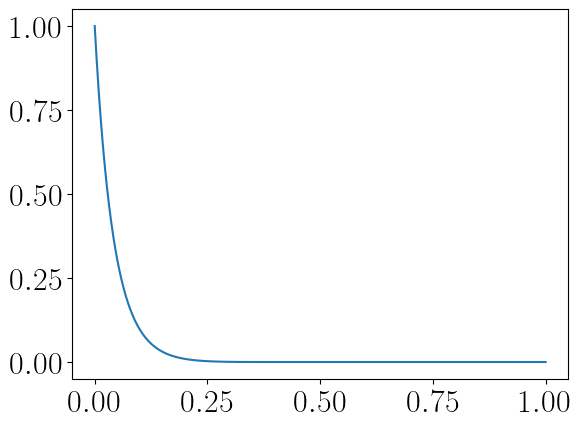

In [103]:
x = np.linspace(0, 1, 10001)
plt.errorbar(x, fc(x)**2)
plt.show()

(1e-12, 2.0)

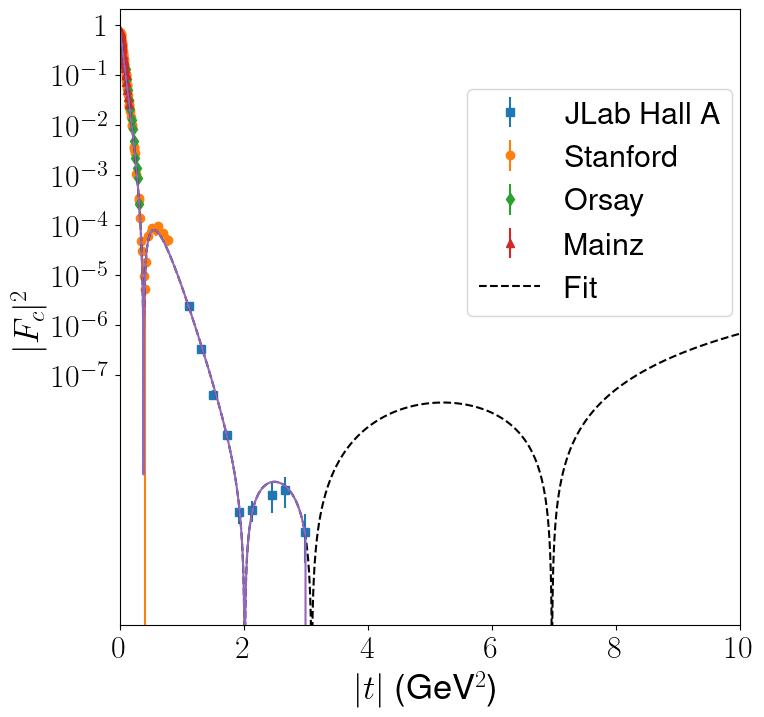

In [104]:
# fig, ax = plt.subplots(1, 1, figsize = (10, 4))
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
# plt.errorbar(q2_stanford_gev, fc_stanford, ls = '', marker = 'o')
# plt.errorbar(q2_stanford2_gev, np.sqrt(fc_squared_stanford2), ls = '', marker = 'o')
# plt.errorbar(q2_slac_gev, abs_fc_slac, ls = '', marker = 'o')

# plt.errorbar(q2_orsay_gev, np.sqrt(fcsquared_orsay), ls = '', marker = 'o')
# plt.errorbar(q2_mainz_gev, fc_mainz, ls = '', marker = 'o')
# plt.errorbar(q2_jlab_gev, fc_jlab_abs, ls = '', marker = 'o')
markers = ['s', 'o', 'd', '^', 'v']
for i, experiment in enumerate(['JLab Hall A', 'Stanford', 'Orsay', 'Mainz']):
    plt.errorbar(df_he4fc.loc[df_he4fc.experiment==experiment].Q2, df_he4fc.loc[df_he4fc.experiment==experiment].Fc_squared, yerr= [df_he4fc.loc[df_he4fc.experiment==experiment].Fc_squared_uncdown, df_he4fc.loc[df_he4fc.experiment==experiment].Fc_squared_uncup], ls ='', marker = markers[i], label = experiment)
min_popt = [  -15.90270616,   408.6089679 , -1509.16153506,  2555.90104941, -2235.08186094,   965.53169709,  -154.69807853,   -13.69047277,  4.99214927]
min_c = 0.7471356
min_n_start = -8
min_n_end = 0
c = min_c
n_start = min_n_start
n_end   = min_n_end
# min_popt = [2.17e1, -6.73e1, 3.68e1, 8.07e1, -6.08e1, -1.10e2, 1.24e2, 6.27e1, -1.79e2, 1.32e2, -4.82e1, 9.02, -6.88e-1]
def laurent_series_c_nstart_nend(x, *par):
    return laurent_series(x, *par, c = c, n_start = n_start, n_end = n_end)

# plt.yscale('log')
# c = 0.5
# p = np.poly1d(np.polyfit(1/(df_he4fc.Q2+c), df_he4fc.Fc, deg = 6))
x = np.linspace(0, 12, 10001)
plt.errorbar(x, laurent_series_c_nstart_nend(x, *popt)**2, color = 'k', ls = '--', label = 'Fit')
plt.errorbar(x, fc(x)**2)
# plt.errorbar(x, laurent_series_c_nstart_nend(x, *popt2)**2, color = 'k', ls = '--', label = 'Fit2')
# plt.ylim([-0.05, 0.05])
plt.yscale('log')
plt.figlegend(loc = 'upper left', bbox_to_anchor = (.54, 0.8))
yticks = 10**(np.linspace(-7, 0, 7+1))
yticklabels = ["$10^{-" +"{}".format(np.abs(i))  +"}$" for i in np.linspace(-7, 0, 7+1, dtype = int)]
yticklabels[-1] = "$1$"
# yticklabels[-1] = 1
plt.yticks(yticks, yticklabels)
# plt.xticks(np.linspace(0, 1.4, 7+1))
plt.ylabel("$|F_c|^2$")
plt.xlabel(r"$|t|$" + " (GeV$^2$)")
plt.xlim([0, 10])
plt.ylim([10**-12, 2])

# plt.savefig("Fc_he4.pdf", bbox_inches = 'tight')

Text(0.5, 0, '$|t|$ (GeV$^2$)')

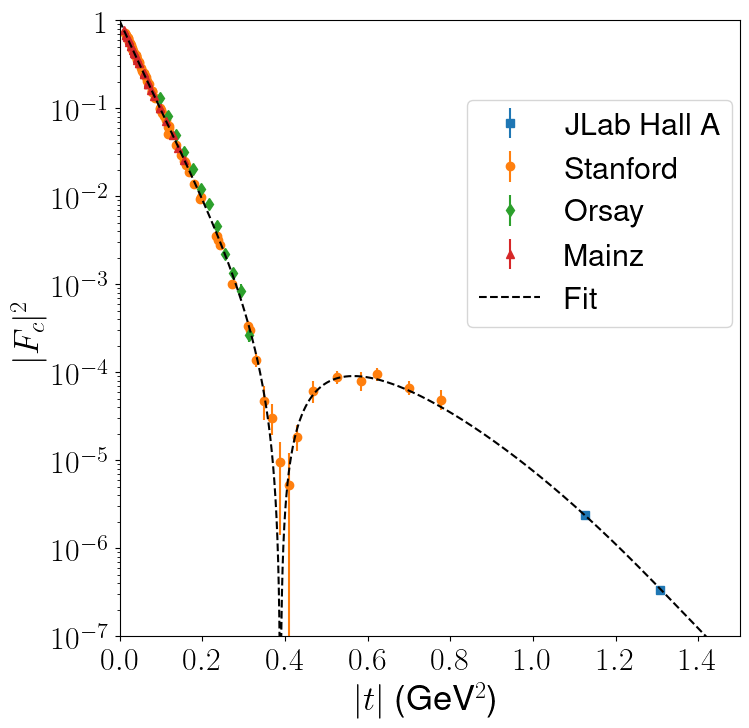

In [21]:
# fig, ax = plt.subplots(1, 1, figsize = (10, 4))
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
# plt.errorbar(q2_stanford_gev, fc_stanford, ls = '', marker = 'o')
# plt.errorbar(q2_stanford2_gev, np.sqrt(fc_squared_stanford2), ls = '', marker = 'o')
# plt.errorbar(q2_slac_gev, abs_fc_slac, ls = '', marker = 'o')

# plt.errorbar(q2_orsay_gev, np.sqrt(fcsquared_orsay), ls = '', marker = 'o')
# plt.errorbar(q2_mainz_gev, fc_mainz, ls = '', marker = 'o')
# plt.errorbar(q2_jlab_gev, fc_jlab_abs, ls = '', marker = 'o')
markers = ['s', 'o', 'd', '^', 'v']
for i, experiment in enumerate(['JLab Hall A', 'Stanford', 'Orsay', 'Mainz']):
    plt.errorbar(df_he4fc.loc[df_he4fc.experiment==experiment].Q2, df_he4fc.loc[df_he4fc.experiment==experiment].Fc_squared, yerr= [df_he4fc.loc[df_he4fc.experiment==experiment].Fc_squared_uncdown, df_he4fc.loc[df_he4fc.experiment==experiment].Fc_squared_uncup], ls ='', marker = markers[i], label = experiment)
min_popt = [  -15.90270616,   408.6089679 , -1509.16153506,  2555.90104941, -2235.08186094,   965.53169709,  -154.69807853,   -13.69047277,  4.99214927]
min_c = 0.7471356
min_n_start = -8
min_n_end = 0
c = min_c
n_start = min_n_start
n_end   = min_n_end
# min_popt = [2.17e1, -6.73e1, 3.68e1, 8.07e1, -6.08e1, -1.10e2, 1.24e2, 6.27e1, -1.79e2, 1.32e2, -4.82e1, 9.02, -6.88e-1]
def laurent_series_c_nstart_nend(x, *par):
    return laurent_series(x, *par, c = c, n_start = n_start, n_end = n_end)

# plt.yscale('log')
# c = 0.5
# p = np.poly1d(np.polyfit(1/(df_he4fc.Q2+c), df_he4fc.Fc, deg = 6))
x = np.linspace(0, 2, 10001)
plt.errorbar(x, laurent_series_c_nstart_nend(x, *min_popt)**2, color = 'k', ls = '--', label = 'Fit')
# plt.ylim([-0.05, 0.05])
plt.xlim([0, 2])
plt.ylim([10**-7, 1])
plt.yscale('log')
plt.figlegend(loc = 'upper left', bbox_to_anchor = (.54, 0.8))
yticks = 10**(np.linspace(-7, 0, 7+1))
yticklabels = ["$10^{-" +"{}".format(np.abs(i))  +"}$" for i in np.linspace(-7, 0, 7+1, dtype = int)]
yticklabels[-1] = "$1$"
# yticklabels[-1] = 1
plt.yticks(yticks, yticklabels)
plt.xticks(np.linspace(0, 1.4, 7+1))
plt.ylabel("$|F_c|^2$")
plt.xlabel(r"$|t|$" + " (GeV$^2$)")

# plt.savefig("Fc_he4.pdf", bbox_inches = 'tight')

In [22]:
min_c

0.7471356

In [23]:
def cbar_e(t):
    return laurent_series_c_nstart_nend(t, *min_popt) * (1+t/0.71)**2

def cbar_e2(t):
    c = 0.7471356
    return (-15.90270616 * (t+c)**(-8) + 408.6089679* (t+c)**(-7) - 1509.16153506 * (t+c)**(-6) + 2555.90104941 * (t+c)**(-5) -2235.08186094 * (t+c)**(-4) + 965.53169709 * (t+c)**(-3) -154.69807853*(t+c)**(-2) - 13.69047277 * (t+c)**(-1) + 4.99214927) * (1+t/0.71)**2/134.346402

In [24]:
1/137.036*(2/3)**2 * (16*3.14159*0.3)**2/3/3.097**3*389379*1.0952/4/3.14159/4

70.21273593977833

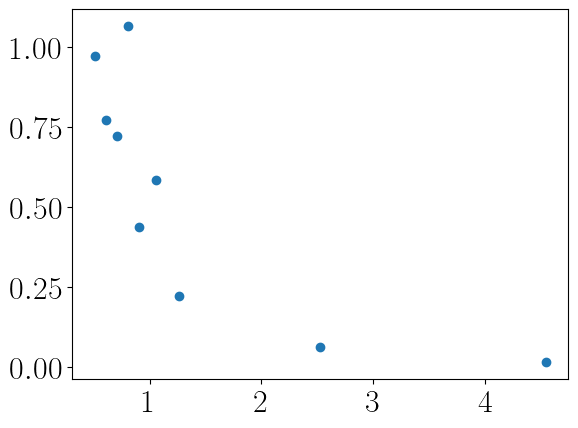

In [25]:
df = pd.read_csv("jpsi_007_dat.csv")
plt.scatter(df.loc[df.avg_E>10.5].avg_abs_t, df.loc[df.avg_E>10.5].dsdt_nb)
plt.show()

In [26]:
np.unique(df.avg_E)

array([ 8.8 ,  9.  ,  9.17,  9.18,  9.32,  9.33,  9.47,  9.48,  9.62,
        9.63,  9.77,  9.78,  9.92,  9.93, 10.07, 10.08, 10.22, 10.23,
       10.38, 10.39, 10.53, 10.54, 10.55, 10.56])

In [27]:
mp = 0.938272081
mHe4 = 3.7273794066
mJpsi = 3.09600

def qgamma(W, Q2, M = mHe4, Mv = mJpsi):
    return 1/2/W*np.sqrt(W**4 - 2* (-Q2 + M**2)*W**2 + (-Q2 - M**2)**2)

def qvector(W, M = mHe4, Mv = mJpsi):
    return 1/2/W*np.sqrt(W**4 - 2 *(Mv**2 + M**2)*W**2 + (Mv**2 - M**2)**2)

def Egamma(W, Q2, M = mHe4, Mv = mJpsi):
    return np.sqrt(-Q2 + qgamma(W,Q2, M = M, Mv = Mv)**2)

def Evector(W, M = mHe4, Mv = mJpsi):
    return np.sqrt(Mv**2 + qvector(W, M = M, Mv = Mv)**2)

def td(W, Q2, theta, M = mHe4, Mv = mJpsi):
    return -(-Q2 + Mv**2 - 2*Egamma(W,Q2, M = M, Mv = Mv)*Evector(W, M = M, Mv = Mv) + 2 * qgamma(W, Q2, M = M, Mv = Mv) * qvector(W, M = M, Mv = Mv) * np.cos(theta))

def tmin(W,Q2, M = mHe4, Mv = mJpsi):
    return td(W, Q2, 0, M = M, Mv = Mv)

def tmax(W, Q2, M = mHe4, Mv = mJpsi):
    return td(W, Q2, np.pi, M = M, Mv = Mv)

def Egamma_photo(W, M = mHe4, Mv = mJpsi):
    return (W**2 - M**2)/2/M

def W_from_egamma(Egamma, M= mHe4, Mv = mJpsi):
    return np.sqrt(2*M*Egamma + M**2)

In [28]:
df.columns

Index(['setting', 'idx', 'E_idx', 't_idx', 'E_low', 'E_high', 'abs_t_tmin_low',
       'abst_t_tmin_high', 'avg_E', 'avg_abs_t_tmin', 'avg_abs_t', 'dsdt_nb',
       'stat_error', 'sys_error', 'tot_error'],
      dtype='object')

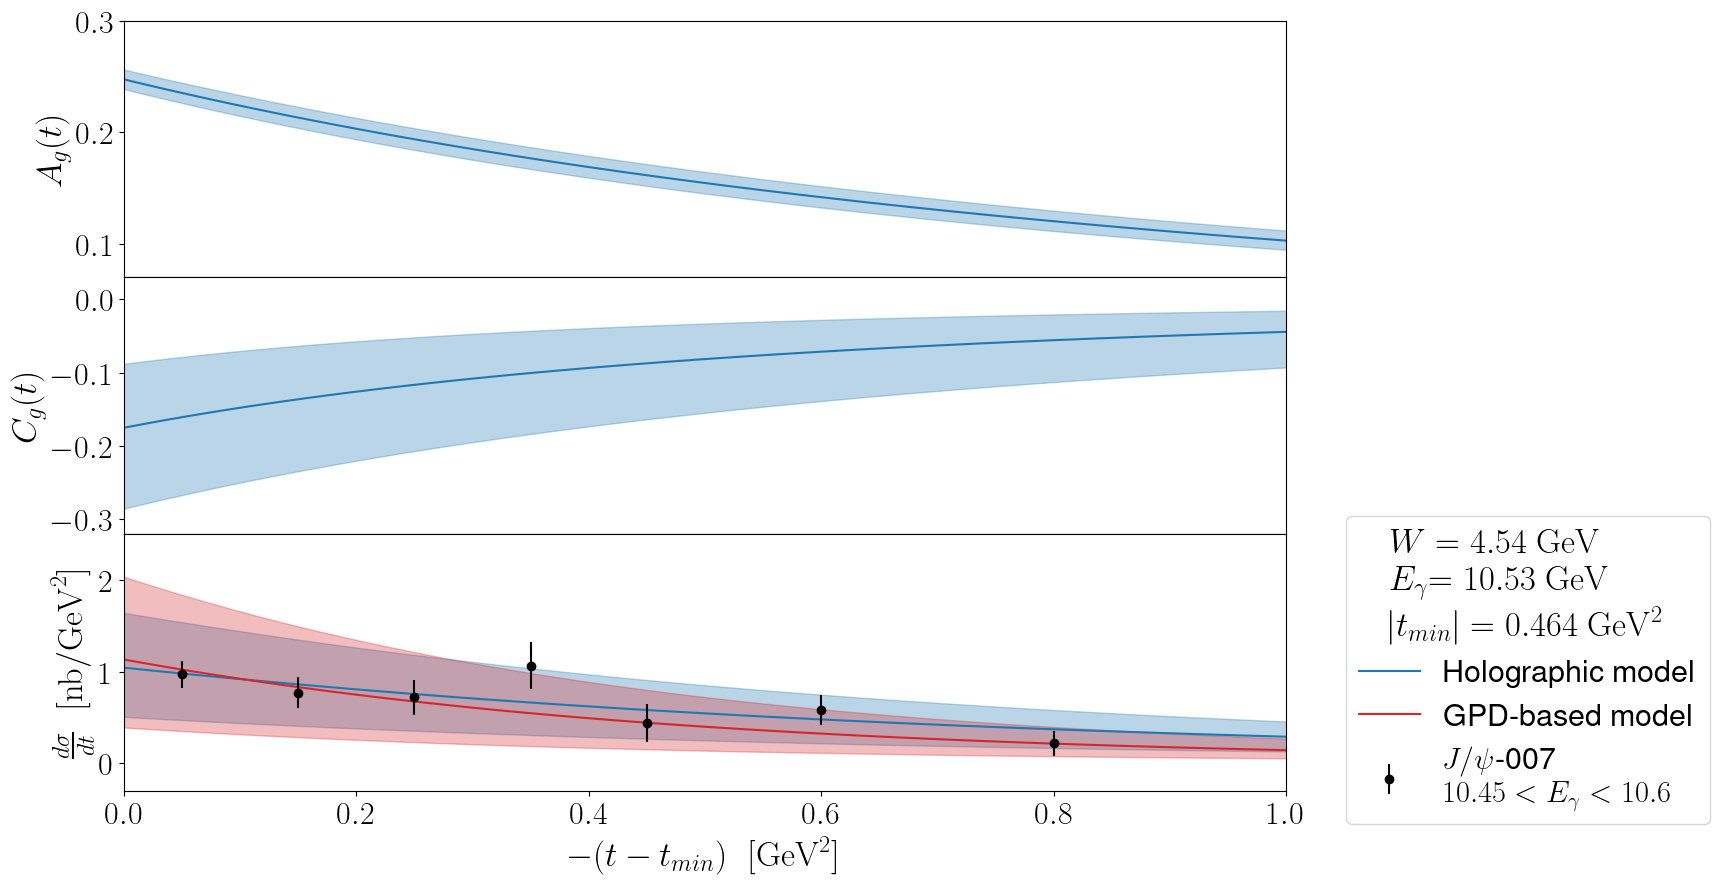

In [29]:
fig, ax = plt.subplots(3, 1, figsize = (15, 10))
m_A = 1.575
m_A_err = .059
m_C = 1.12
m_C_err = 0.21
C_0 = -.45
C_0_err = 0.132

x = np.linspace(0, 2, 101)
Egammad = 10.525

W = W_from_egamma(Egammad, M= mp)
s = W**2
par = [m_A, C_0, m_C]
A_g_nuc, C_g_nuc, dsigmadt_nuc = holographic_model(s, x, *par)
dsigmadt_nuc_holog_nominal = dsigmadt_nuc
A_g_2 = A_g_nuc
C_g_2 = C_g_nuc
dsigmadt_nuc_gpd               = gpd_based_model(x, s, A_g_nuc, C_g_nuc)
dsigmadt_nuc_gpd_nominal  = dsigmadt_nuc_gpd

# par = [1.575, -0.45, 1.12]
# par = [1.64, -0.84, 1.12]
# par = [1.13, -1.0, 0.48]
# par = [1.32, C_0, m_S]
# par = [2.71, -0.2, 1.28]

dsigmadt_nuc_max     = dsigmadt_nuc
dsigmadt_nuc_min     = dsigmadt_nuc
dsigmadt_nuc_gpd_max = dsigmadt_nuc_gpd
dsigmadt_nuc_gpd_min = dsigmadt_nuc_gpd

A_g_nuc_max = A_g_nuc
A_g_nuc_min = A_g_nuc
C_g_nuc_max = C_g_nuc
C_g_nuc_min = C_g_nuc

for i in range(1000):
    par = [m_A+np.random.uniform(-1, 1)*m_A_err, C_0+np.random.uniform(-1, 1)*C_0_err, m_C+np.random.uniform(-1, 1)*m_C_err]
    A_g_nuc, C_g_nuc, dsigmadt_nuc = holographic_model(s, x, *par)
    A_g_nuc_max = np.maximum(A_g_nuc, A_g_nuc_max)
    A_g_nuc_min = np.minimum(A_g_nuc, A_g_nuc_min)
    C_g_nuc_max = np.maximum(C_g_nuc, C_g_nuc_max)
    C_g_nuc_min = np.minimum(C_g_nuc, C_g_nuc_min)
    dsigmadt_nuc_gpd               = gpd_based_model(x, s, A_g_nuc, C_g_nuc)
    dsigmadt_nuc_max = np.maximum(dsigmadt_nuc_max, dsigmadt_nuc)
    dsigmadt_nuc_min = np.minimum(dsigmadt_nuc_min, dsigmadt_nuc)
    dsigmadt_nuc_gpd_max = np.maximum(dsigmadt_nuc_gpd_max, dsigmadt_nuc_gpd)
    dsigmadt_nuc_gpd_min = np.minimum(dsigmadt_nuc_gpd_min, dsigmadt_nuc_gpd)
    # if dsigmadt_nuc_max<dsigmadt_nuc:
    #     dsigmadt_nuc_max = dsigmadt_nuc
    # if dsigmadt_nuc_min>dsigmadt_nuc:
    #     dsigmadt_nuc_min = dsigmadt_nuc
    # if dsigmadt_nuc_gpd_max<dsigmadt_nuc_gpd:
    #     dsigmadt_nuc_gpd_max = dsigmadt_nuc_gpd
    # if dsigmadt_nuc_gpd_min>dsigmadt_nuc_gpd:
    #     dsigmadt_nuc_gpd_min = dsigmadt_nuc_gpd

ax[0].plot(x - tmin(W, 0, mp, mJpsi), A_g_2, color = 'tab:blue')
ax[0].fill_between(x - tmin(W, 0, mp, mJpsi), A_g_nuc_min, A_g_nuc_max, color = 'tab:blue', alpha = 0.3)
# ax[0].fill_between(x - tmin(W, 0, mp, mJpsi), gpd_based_model(x, W, A_g_nuc, D_g_nuc), color = 'tab:red')

ax[0].set_xlim([0, 1])# 3])
ax[0].set_ylim([0.07, 0.3])
ax[0].set_xlabel(r"$-(t-t_{min})~~[\mathrm{GeV}^2]$")
ax[0].set_ylabel(r"$A_g(t)$")

ax[1].plot(x - tmin(W, 0, mp, mJpsi), C_g_2, color = 'tab:blue')
ax[1].fill_between(x - tmin(W, 0, mp, mJpsi), C_g_nuc_min, C_g_nuc_max, color = 'tab:blue', alpha = 0.3)
# ax[1].fill_between(x - tmin(W, 0, mp, mJpsi), gpd_based_model(x, W, C_g_nuc, D_g_nuc), color = 'tab:red')

ax[1].set_xlim([0, 1])# 3])
ax[1].set_ylim([-0.32, 0.03])
ax[1].set_xlabel(r"$-(t-t_{min})~~[\mathrm{GeV}^2]$")
ax[1].set_ylabel(r"$C_g(t)$")



ax[2].plot(x - tmin(W, 0, mp, mJpsi), dsigmadt_nuc_holog_nominal, color = 'tab:blue', label = "Holographic model")
# ax[2].plot(x - tmin(W, 0, mp, mJpsi), gpd_based_model(x, W, A_g_nuc, C_g_nuc), color = 'tab:red')
ax[2].plot(x - tmin(W, 0, mp, mJpsi), dsigmadt_nuc_gpd_nominal, color = 'tab:red', label = "GPD-based model")
ax[2].fill_between(x - tmin(W, 0, mp, mJpsi), dsigmadt_nuc_min, dsigmadt_nuc_max, color = 'tab:blue', alpha = 0.3)
ax[2].fill_between(x - tmin(W, 0, mp, mJpsi), dsigmadt_nuc_gpd_min, dsigmadt_nuc_gpd_max, color = 'tab:red', alpha = 0.3)

ax[2].errorbar(df.loc[df.avg_E>10.5].avg_abs_t_tmin, df.loc[df.avg_E>10.5].dsdt_nb, yerr = df.loc[df.avg_E>10.5].tot_error, marker = 'o', ls = '', color = 'k', label = '$J/\psi$-007\n $10.45<E_\gamma<10.6$')

# ax[2].fill_between(x - tmin(W, 0, mp, mJpsi), gpd_based_model(x, W, A_g_nuc, D_g_nuc), color = 'tab:red')

ax[2].set_xlim([0, 1])# 3])
ax[2].set_ylim([-0.3, 2.5])
ax[2].set_xlabel(r"$-(t-t_{min})~~[\mathrm{GeV}^2]$")
ax[2].set_ylabel(r"$\frac{d\sigma}{dt}~~[\mathrm{nb/GeV}^2]$")

ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)
plt.subplots_adjust(hspace=0)
plt.figlegend(loc = 'upper left', bbox_to_anchor = (0.93, 0.4), title = "$W = {:.2f}$".format(W)+"$~\mathrm{GeV}$\n"+"$E_{\gamma}$"+"$={:.2f}$".format(Egammad)+"$~\mathrm{GeV}$\n $|t_{min}|=$"+ " ${:.3f}$".format(tmin(W, 0, M = mp)) +"$~\mathrm{GeV}^2$")
plt.savefig("Cross-section_nucleon.pdf", bbox_inches = 'tight')

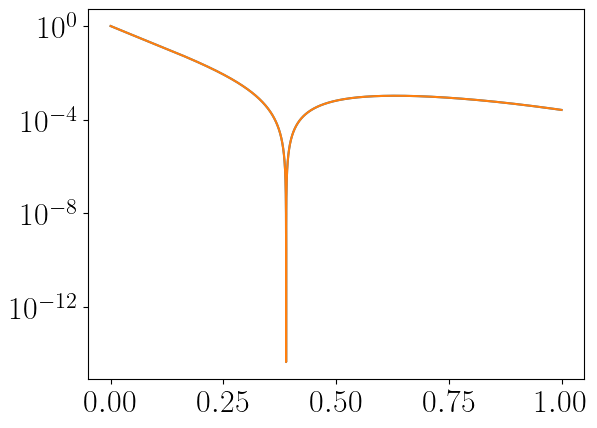

In [30]:
dummy = np.linspace(0, 1, 1000001)
sigmoid = 1/(1+np.exp( -(dummy-0.4)/0.05))
plt.plot(dummy, (cbar_e(dummy))**2)
plt.plot(dummy, (cbar_e(dummy))**2)
plt.yscale('log')
plt.show()

In [31]:
#Code block from S. Prasad
def gpd_based_model_he4(x1, s, A, C):
    A = A*cbar_e(x1)
    C = 16*C*cbar_e(x1)
    const1_unitconv=70.231;
    xi = (-x1 - mJpsi**2)/(2*mHe4**2+mJpsi**2 - 2*s +x1);
    D = 4 * C
    const_2=1/pow(s-mHe4*mHe4,2);
    myfit =const1_unitconv*const_2*(4 /pow(xi, 4))*(A + xi**2 * D)**2;
    return myfit


In [45]:
def dsigma_dt(W2, t, Mt, Mv):
    s = W2; # s = W^2
    Eg = 0.5 * (W2 / Mt - Mt);
    abst = -t;
    t0 = 0.7471356;
    cbar_e = (-15.90270616 * pow(abst+t0, -8) + 408.6089679* pow(abst+t0, -7)
    - 1509.16153506 * pow(abst+t0, -6) + 2555.90104941 * pow(abst+t0, -5) -2235.08186094 * pow(abst+t0, -4) 
    + 965.53169709 * pow(abst+t0, -3) -154.69807853*pow(abst+t0, -2) - 13.69047277 * pow(abst+t0, -1) + 4.99214927) * (1+abst/0.71)*(1+abst/0.71)/134.567088;
    a_g_proton = 0.414/ pow(1 + abst/1.575/1.575, 3); #tripole
    c_g_proton = -0.45/ pow(1 + abst/1.120/1.120, 3); #tripole
    a_g_he4    = a_g_proton*cbar_e;
    c_g_he4    = 16*c_g_proton*cbar_e;
    xi         = (-abst - Mv*Mv)/(2*Mt*Mt+Mv*Mv - 2*s +abst);
    d_g_he4    = 4*c_g_he4;
    print(d_g_he4)
    G_squared  = (4 /pow(xi, 4))*(a_g_he4 + xi * xi * d_g_he4)*(a_g_he4 + xi * xi * d_g_he4);
    hbarc2_nb  = 389379.0;
    const1_unit_conv = 1/137.036*(2./3.)*(2./3.) * (16.*np.pi*0.3)*(16.*np.pi*0.3)/3/Mv/Mv/Mv*hbarc2_nb*1.0952/4./np.pi/4;
    const2 = 1/pow(s-Mt*Mt, 2);
    xsec = const1_unit_conv * const2 * G_squared;
    return xsec;


In [46]:
dsigma_dt(s, -x, mHe4, mJpsi ),

[-2.87527689e+01 -2.86856978e+01 -2.86187940e+01 ... -7.11657694e-04
 -7.14808686e-04 -7.17961964e-04]


(array([5.09546503e+03, 5.07171834e+03, 5.04808615e+03, ...,
        3.12924816e-06, 3.15702153e-06, 3.18493788e-06]),)

In [47]:
s

20.63098180303408

[-2.87527689e+01 -2.86856978e+01 -2.86187940e+01 ... -7.11657694e-04
 -7.14808686e-04 -7.17961964e-04]


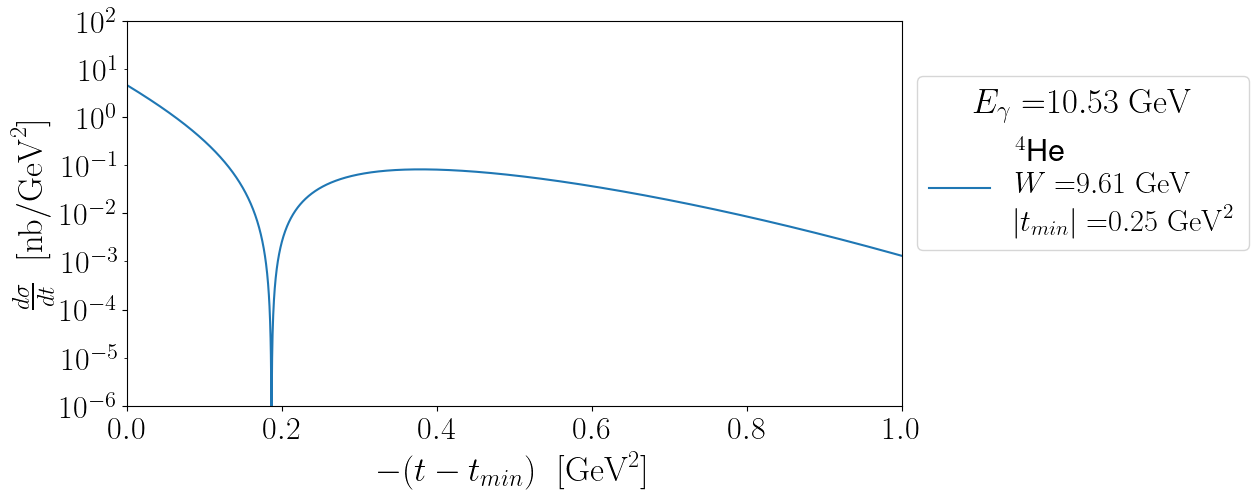

In [53]:
# fig, ax = plt.subplots(1, 1, figsize = (12, 8))
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
# m_A = 1.575
# m_A_err = .059
# m_C = 1.12
# m_C_err = 0.21
# C_0 = -.45
# C_0_err = 0.132

# x = np.linspace(0, 2, 10001)

# Egammad = 10.525

# W = W_from_egamma(Egammad, M= mp)
# s = W**2
# par = [m_A, C_0, m_C]
# A_g_nuc, C_g_nuc, dsigmadt_nuc = holographic_model(s, x, *par)
# dsigmadt_nuc_holog_nominal = dsigmadt_nuc
# A_g_2 = A_g_nuc
# C_g_2 = C_g_nuc
# dsigmadt_nuc_gpd               = gpd_based_model(x, s, A_g_nuc, C_g_nuc)
# dsigmadt_nuc_gpd_nominal  = dsigmadt_nuc_gpd

# ax.plot(x - tmin(W, 0, mp, mJpsi), dsigmadt_nuc_gpd_nominal, color = 'tab:red', label = "Proton\n"+r"$W = $"+"${:.2f}$".format(W)+"$~\mathrm{GeV}$"+"\n" +r"$~~|t_{min}| =$"+"$ {:.2f}$".format(tmin(W, 0, mp, mJpsi))+"$~\mathrm{GeV}^2$")

# W = W_from_egamma(Egammad, M= mHe4)
# par = [m_A, C_0, m_C]
# A_g_nuc, C_g_nuc, dsigmadt_nuc = holographic_model(s, x, *par)
# dsigmadt_nuc_holog_nominal = dsigmadt_nuc
# A_g_2 = 0.414/ (1 + x/1.575**2)**3
# C_g_2 = -0.45/ (1 + x/1.120**2)**3
# dsigmadt_he4_gpd_test          = gpd_based_model_he4(x, s, A_g_2, C_g_2)

ax.plot(x - tmin(10, 0, mHe4, mJpsi), dsigma_dt(100, -x, mHe4, mJpsi ), color = 'tab:blue', label = "$^4$He\n"+r"$W = $"+"${:.2f}$".format(W)+"$~\mathrm{GeV}$"+"\n" +r"$~~|t_{min}| =$"+"$ {:.2f}$".format(tmin(W, 0, mHe4, mJpsi))+"$~\mathrm{GeV}^2$")


ax.set_xlim([0, 1])# 3])
ax.set_xlabel(r"$-(t-t_{min})~~[\mathrm{GeV}^2]$")
ax.set_ylabel(r"$\frac{d\sigma}{dt}~~[\mathrm{nb/GeV}^2]$")
ax.set_yscale('log')
# ax.set_yticks([10**-6, 10**-3, 1, 10**3])
ax.set_yticks(10**(np.linspace(-6, 3, 10)), minor = True)
ax.set_ylim([10**-6, 10**2])

# plt.subplots_adjust(hspace=0)
# plt.figlegend(loc = 'upper left', bbox_to_anchor = (0.9, 0.9), title = "$W = 10~\mathrm{GeV}$\n $E_{\gamma}=11.6~\mathrm{GeV}$\n $|t_{min}|=0.202~\mathrm{GeV}^2$")
plt.figlegend(loc = 'upper left', bbox_to_anchor = (0.9, 0.8), title = "$E_{\gamma} =$"+"$ {:.2f}$".format(Egammad) +"$~\mathrm{GeV}$")
# plt.figlegend(loc = 'upper left', bbox_to_anchor = (0.5, 0.5), title = "$E_{\gamma} =$"+"$ {:.2f}$".format(Egammad) +"$~\mathrm{GeV}$")
plt.savefig("Cross-section_he4.pdf", bbox_inches = 'tight')

In [34]:
gpd_based_model_he4(9.19**2, np.linspace(0, 1, 101), mHe4, mJpsi)

array([1.61476312e+10, 1.61705765e+10, 1.61935713e+10, 1.62166156e+10,
       1.62397097e+10, 1.62628536e+10, 1.62860476e+10, 1.63092918e+10,
       1.63325863e+10, 1.63559313e+10, 1.63793268e+10, 1.64027732e+10,
       1.64262704e+10, 1.64498187e+10, 1.64734182e+10, 1.64970690e+10,
       1.65207714e+10, 1.65445253e+10, 1.65683311e+10, 1.65921889e+10,
       1.66160987e+10, 1.66400608e+10, 1.66640753e+10, 1.66881424e+10,
       1.67122622e+10, 1.67364348e+10, 1.67606605e+10, 1.67849394e+10,
       1.68092716e+10, 1.68336572e+10, 1.68580966e+10, 1.68825897e+10,
       1.69071368e+10, 1.69317380e+10, 1.69563936e+10, 1.69811035e+10,
       1.70058681e+10, 1.70306874e+10, 1.70555617e+10, 1.70804910e+10,
       1.71054756e+10, 1.71305156e+10, 1.71556112e+10, 1.71807625e+10,
       1.72059698e+10, 1.72312331e+10, 1.72565527e+10, 1.72819287e+10,
       1.73073613e+10, 1.73328506e+10, 1.73583968e+10, 1.73840001e+10,
       1.74096607e+10, 1.74353787e+10, 1.74611543e+10, 1.74869877e+10,
      

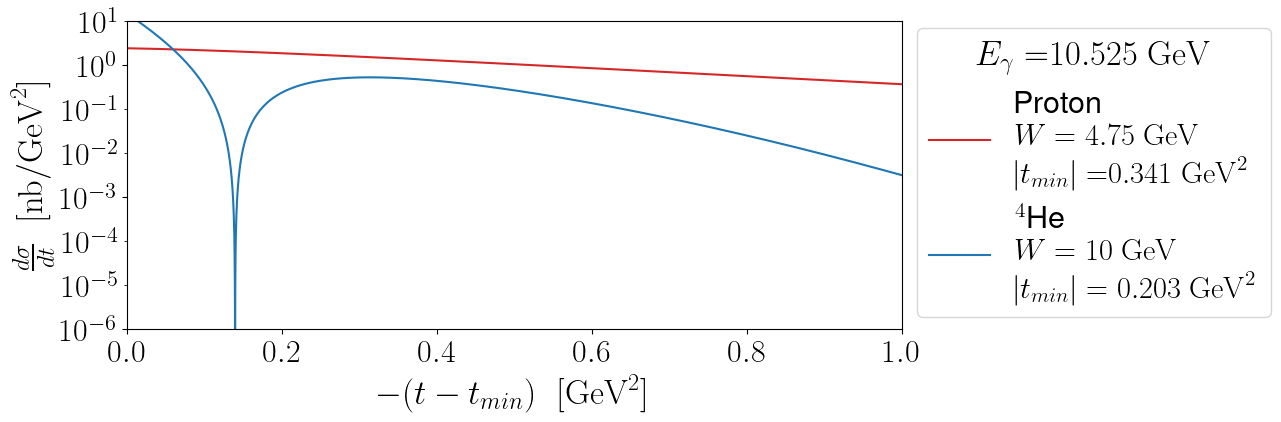

In [35]:
fig, ax = plt.subplots(1, 1, figsize = (10, 4))
m_A = 1.575
m_A_err = .059
m_C = 1.12
m_C_err = 0.21
C_0 = -.45
C_0_err = 0.132

x = np.linspace(0, 1.3, 10001)

Egammad = 10.525

W = W_from_egamma(Egammad, M= mp)
s = W**2
par = [m_A, C_0, m_C]
A_g_nuc, C_g_nuc, dsigmadt_nuc = holographic_model(s, x, *par)
dsigmadt_nuc_holog_nominal = dsigmadt_nuc
A_g_2 = A_g_nuc
C_g_2 = C_g_nuc
dsigmadt_nuc_gpd               = gpd_based_model(x, s, A_g_nuc, C_g_nuc)
dsigmadt_nuc_gpd_nominal  = dsigmadt_nuc_gpd

# dsigmadt_nuc_gpd_max = dsigmadt_nuc_gpd
# dsigmadt_nuc_gpd_min = dsigmadt_nuc_gpd

# A_g_nuc_max = A_g_nuc
# A_g_nuc_min = A_g_nuc
# C_g_nuc_max = C_g_nuc
# C_g_nuc_min = C_g_nuc

# for i in range(1000):
#     par = [m_A+np.random.uniform(-1, 1)*m_A_err, C_0+np.random.uniform(-1, 1)*C_0_err, m_C+np.random.uniform(-1, 1)*m_C_err]
#     A_g_nuc, C_g_nuc, dsigmadt_nuc = holographic_model(s, x, *par)
#     A_g_nuc_max = np.maximum(A_g_nuc, A_g_nuc_max)
#     A_g_nuc_min = np.minimum(A_g_nuc, A_g_nuc_min)
#     C_g_nuc_max = np.maximum(C_g_nuc, C_g_nuc_max)
#     C_g_nuc_min = np.minimum(C_g_nuc, C_g_nuc_min)
#     dsigmadt_nuc_gpd               = gpd_based_model(x, s, A_g_nuc, C_g_nuc)
#     dsigmadt_nuc_gpd_max = np.maximum(dsigmadt_nuc_gpd_max, dsigmadt_nuc_gpd)
#     dsigmadt_nuc_gpd_min = np.minimum(dsigmadt_nuc_gpd_min, dsigmadt_nuc_gpd)


Egammad = 10.525

W = W_from_egamma(Egammad, M= mHe4)
par = [m_A, C_0, m_C]
A_g_nuc, C_g_nuc, dsigmadt_nuc = holographic_model(s, x, *par)
dsigmadt_nuc_holog_nominal = dsigmadt_nuc
A_g_2 = 0.414/ (1 + x/1.575**2)**3
C_g_2 = -0.45/ (1 + x/1.120**2)**3
dsigmadt_he4_gpd_test          = gpd_based_model_he4(x, s, A_g_2, C_g_2)

# dsigmadt_he4_gpd_max = dsigmadt_he4_gpd
# dsigmadt_he4_gpd_min = dsigmadt_he4_gpd
ax.plot(x - tmin(W, 0, mp, mJpsi), dsigmadt_nuc_gpd_nominal, color = 'tab:red', label = "Proton\n"+r"$W = 4.75~\mathrm{GeV}$"+"\n" +r"$~~|t_{min}| =$"+"$ 0.341~\mathrm{GeV}^2$")
# ax.plot(x - tmin(W, 0, mHe4, mJpsi), dsigmadt_he4_gpd_nominal, color = 'tab:blue', label = "$^4$He\n"+r"$W = 10~\mathrm{GeV}$" +"\n" + r"$~~|t_{min}| = 0.203~\mathrm{GeV}^2$")
# ax.plot(x - tmin(W, 0, mHe4, mJpsi), dsigmadt_he4_gpd_test)#, color = 'tab:blue', label = "$^4$He\n"+r"$W = 10~\mathrm{GeV}$" +"\n" + r"$~~|t_{min}| = 0.203~\mathrm{GeV}^2$")

ax.plot(x - tmin(W, 0, mHe4, mJpsi), dsigma_dt(s, -x, mHe4, mJpsi ), color = 'tab:blue', label = "$^4$He\n"+r"$W = 10~\mathrm{GeV}$" +"\n" + r"$~~|t_{min}| = 0.203~\mathrm{GeV}^2$")


# A_g_nuc_max = A_g_nuc
# A_g_nuc_min = A_g_nuc
# C_g_nuc_max = C_g_nuc
# C_g_nuc_min = C_g_nuc

# for i in range(1000):
#     par = [m_A+np.random.uniform(-1, 1)*m_A_err, C_0+np.random.uniform(-1, 1)*C_0_err, m_C+np.random.uniform(-1, 1)*m_C_err]
#     A_g_nuc, C_g_nuc, dsigmadt_nuc = holographic_model(s, x, *par)
#     A_g_nuc_max = np.maximum(A_g_nuc, A_g_nuc_max)
#     A_g_nuc_min = np.minimum(A_g_nuc, A_g_nuc_min)
#     C_g_nuc_max = np.maximum(C_g_nuc, C_g_nuc_max)
#     C_g_nuc_min = np.minimum(C_g_nuc, C_g_nuc_min)
#     dsigmadt_he4_gpd               = gpd_based_model_he4(x, s, A_g_nuc, C_g_nuc)
#     dsigmadt_he4_gpd_max = np.maximum(dsigmadt_he4_gpd_max, dsigmadt_he4_gpd)
#     dsigmadt_he4_gpd_min = np.minimum(dsigmadt_he4_gpd_min, dsigmadt_he4_gpd)

# ax[0].plot(x - tmin(W, 0, mHe4, mJpsi), A_g_2, color = 'tab:blue')
# ax[0].fill_between(x - tmin(W, 0, mHe4, mJpsi), A_g_nuc_min, A_g_nuc_max, color = 'tab:blue', alpha = 0.3)
# # ax[0].fill_between(x - tmin(W, 0, mHe4, mJpsi), gpd_based_model(x, W, A_g_nuc, D_g_nuc), color = 'tab:red')

# ax[0].set_xlim([0, 1])# 3])
# ax[0].set_ylim([0.07, 0.3])
# ax[0].set_xlabel(r"$-(t-t_{min})~~[\mathrm{GeV}^2]$")
# ax[0].set_ylabel(r"$A_g(t)$")

# ax[1].plot(x - tmin(W, 0, mHe4, mJpsi), C_g_2, color = 'tab:blue')
# ax[1].fill_between(x - tmin(W, 0, mHe4, mJpsi), C_g_nuc_min, C_g_nuc_max, color = 'tab:blue', alpha = 0.3)
# # ax[1].fill_between(x - tmin(W, 0, mHe4, mJpsi), gpd_based_model(x, W, C_g_nuc, D_g_nuc), color = 'tab:red')

# ax[1].set_xlim([0, 1])# 3])
# ax[1].set_ylim([-0.32, 0.03])
# ax[1].set_xlabel(r"$-(t-t_{min})~~[\mathrm{GeV}^2]$")
# ax[1].set_ylabel(r"$C_g(t)$")



# ax.plot(x - tmin(W, 0, mHe4, mJpsi), dsigmadt_nuc_holog_nominal, color = 'tab:blue', label = "Holographic model")
# ax.plot(x - tmin(W, 0, mHe4, mJpsi), gpd_based_model(x, W, A_g_nuc, C_g_nuc), color = 'tab:red')
# ax.plot(x - tmin(W, 0, mp, mJpsi), dsigmadt_nuc_gpd_nominal, color = 'tab:red', label = "Proton\n"+r"$W = 4.75~\mathrm{GeV}$"+"\n" +r"$~~|t_{min}| = 0.341~\mathrm{GeV}^2$")
# ax.plot(x - tmin(W, 0, mHe4, mJpsi), dsigmadt_he4_gpd_nominal, color = 'tab:blue', label = "$^4$He\n"+r"$W = 10~\mathrm{GeV}$" +"\n" + r"$~~|t_{min}| = 0.203~\mathrm{GeV}^2$")
# ax.fill_between(x - tmin(W, 0, mHe4, mJpsi), dsigmadt_nuc_min, dsigmadt_nuc_max, color = 'tab:blue', alpha = 0.3)
# ax.fill_between(x - tmin(W, 0, mHe4, mJpsi), dsigmadt_nuc_gpd_min, dsigmadt_nuc_gpd_max, color = 'tab:red', alpha = 0.3)
# ax.fill_between(x - tmin(W, 0, mHe4, mJpsi), gpd_based_model(x, W, A_g_nuc, D_g_nuc), color = 'tab:red')

ax.set_xlim([0, 1])# 3])
# ax.set_ylim([-0.3, 2.5])
ax.set_xlabel(r"$-(t-t_{min})~~[\mathrm{GeV}^2]$")
ax.set_ylabel(r"$\frac{d\sigma}{dt}~~[\mathrm{nb/GeV}^2]$")
ax.set_yscale('log')
ax.set_yticks([10**-6, 10**-3, 1, 10**3])
ax.set_yticks(10**(np.linspace(-6, 3, 10)), minor = True)
ax.set_ylim([10**-6, 10**1])

# ax[0].get_xaxis().set_visible(False)
# ax[1].get_xaxis().set_visible(False)
plt.subplots_adjust(hspace=0)
# plt.figlegend(loc = 'upper left', bbox_to_anchor = (0.9, 0.75), title = "$W = 10~\mathrm{GeV}$\n $E_{\gamma}=11.6~\mathrm{GeV}$\n $|t_{min}|=0.202~\mathrm{GeV}^2$")
plt.figlegend(loc = 'upper left', bbox_to_anchor = (0.9, 0.9), title = "$E_{\gamma} =$"+"$ {}$".format(Egammad) +"$~\mathrm{GeV}$")
plt.savefig("Cross-section_he4.pdf", bbox_inches = 'tight')

In [36]:
print(W_from_egamma(11.55, mp), W_from_egamma(11.55, mHe4))
print(tmin(W_from_egamma(11.55, mp), 0, mp), tmin(W_from_egamma(11.55, mHe4), 0, mHe4))

4.7491514577958105 9.999791074477795
0.3406267052076677 0.20255894704657607


9.772213924532206 12.310094515429245 0.004436982025024694


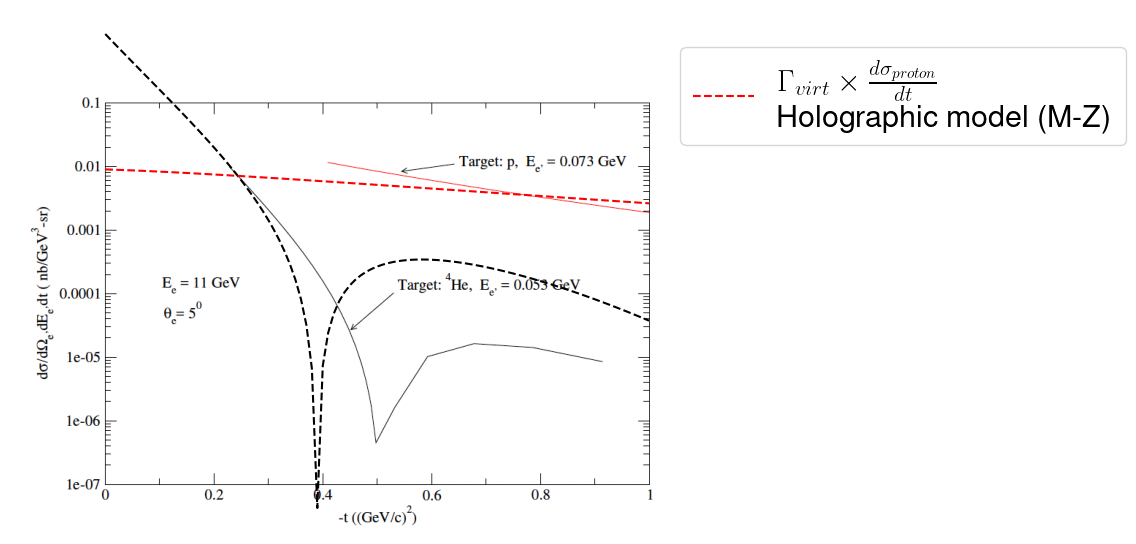

In [55]:
def transform(abst, dsdt, Gamma):
    abst = 130 + (875-130)*abst
    dsdt = 555 + (np.log10(dsdt*Gamma) + 7)/(-1+7)*(35-555)
    return np.array(abst), np.array(dsdt)

mHe4 = 3.7273794066
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
img = mpimg.imread('/Users/sangbaek.lee/Desktop/harry_calculation.png')
imgplot = plt.imshow(img)
ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
# ax.axvline(130)
# ax.axvline(875)
# ax.axhline(35)
# ax.axhline(555)
plt.axis('off')
hc2  = 0.38938
alpha = 1/137# * hc2
Q2 = 2*11*0.053*(1-np.cos(np.radians(5)))
q2 = 0.053**2
nu = 11-0.053
W2 = mHe4**2 + 2*mHe4*nu - Q2
t_1 = np.linspace(0, 1, 101)

s = W2

kgamma = (W2-mHe4)/2/mHe4
print(np.sqrt(W2), kgamma, Q2)
epsilon = 1/(1+2*nu**2/Q2*np.tan(0.5*np.radians(5))**2)
Gamma = alpha/2/np.pi**2  * 0.053/11 * kgamma/Q2 *1/(1-epsilon)

par = [m_A, C_0, m_C]
A_g_nuc, C_g_nuc, dsigmadt_nuc = holographic_model(s, t_1, *par)

dsigmadt_he4_gpd               = gpd_based_model_he4(t_1, s, A_g_nuc, C_g_nuc)
dsigmadt_he4_gpd_nominal       = dsigmadt_he4_gpd
plt.plot(*transform(t_1, dsigmadt_he4_gpd_nominal, Gamma), ls = '--', color = 'k')#, label = r"$\Gamma_{virt} \times \frac{d\sigma_{proton}}{dt}$ "+'\n Holographic model (M-Z)')

# plt.scatter(*transform(abst[Eg==10.9], dsdt[Eg==10.9], Gamma), color = 'k', label = r"$\Gamma_{virt} \times \frac{d\sigma_{lAger}}{dt}$ ")#r"$\frac{d\sigma^{^4He}_{lager}}{dt}~\mathrm{[nb/GeV]}^2 \times \Gamma,~\Gamma = \frac{\alpha}{2\pi^2}\frac{\epsilon_f}{\epsilon_i}\frac{k_\gamma}{Q^2}\frac{1}{1-\epsilon}$")
# plt.scatter(*transform(abst[Eg==10.9], 0.4679928134316036*dsdt_modified[Eg==10.9]), color = 'tab:blue', label = "Without \n diffraction minimum")# r"$\frac{d\sigma^{^4He}_{lager}}{dt}~\mathrm{[nb/GeV]}^2 \times \Gamma,~\Gamma = \frac{\alpha}{2\pi^2}\frac{\epsilon_f}{\epsilon_i}\frac{k_\gamma}{Q^2}\frac{1}{1-\epsilon}$")
alpha = 1/137.025
Q2 = 2*11*0.073*(1-np.cos(np.radians(5)))
q2 = 0.073**2
nu = 11-0.073
W2 = mp**2 + 2*mp*nu - Q2
kgamma = (W2-mp)/2/mp
epsilon = 1/(1+2*nu**2/Q2*np.tan(0.5*np.radians(5))**2)
Gamma = alpha/2/np.pi**2  * 0.073/11 * kgamma/Q2 *1/(1-epsilon)



A_g_nuc, C_g_nuc, dsigmadt_nuc = holographic_model(W2, t_1, *par)


# plt.plot(*transform(t_1, get_funcs(W2, t_1)[2]), ls = '--', color = 'r', label = r"$\Gamma_{virt} \times \frac{d\sigma_{proton}}{dt}$ "+'\n Holographic model (M-Z)')
plt.plot(*transform(t_1, dsigmadt_nuc, Gamma), ls = '--', color = 'r', label = r"$\Gamma_{virt} \times \frac{d\sigma_{proton}}{dt}$ "+'\n Holographic model (M-Z)')

alpha = 1/137.025
Q2 = 2*11*0.053*(1-np.cos(np.radians(5)))
q2 = 0.053**2
nu = 11-0.053
W2 = mHe4**2 + 2*mHe4*nu - Q2
kgamma = (W2-mHe4)/2/mHe4
epsilon = 1/(1+2*nu**2/Q2*np.tan(0.5*np.radians(5))**2)
Gamma = alpha/2/np.pi**2  * 0.073/11 * kgamma/Q2 *1/(1-epsilon)

s = W2


# plt.plot(*transform(t_grid_dsdt+0.2, dsdt_grid), ls = '--', color = 'k', label = r"$\Gamma_{virt} \times \frac{d\sigma_{^4He}}{dt}$ "+'\n Impulse Approximation (H-Z)')
# x = np.linspace(-10, -1, 9+1)
# x = 10**x
# plt.plot(*transform(np.zeros_like(x), x, 1),  color ='k', marker = '+')
# plt.annotate('1e-08', xy = transform(0, 1e-8, 1), xytext = transform(-0.08, 1e-8, 1), size = 10)
# plt.annotate('1e-09', xy = transform(0, 1e-9, 1), xytext = transform(-0.08, 1e-9, 1), size = 10)
# plt.annotate('1e-10', xy = transform(0, 1e-10, 1), xytext = transform(-0.08, 1e-10, 1), size = 10)
# plt.ylabel(r"$\frac{d\sigma}{dt} (E_{\gamma}=10.9 \mathrm{GeV})$" + " [nb/GeV$^2$]")
# plt.xlabel(r"$|t|$" + " [GeV$^2$]")
plt.figlegend(bbox_to_anchor = (1.5, 0.9))#, title =r"$E_{\gamma}=10.9$" + " GeV")
# plt.yscale('log')
# plt.xticks([0.2, 0.4, 0.6, 0.8, 1])
plt.tight_layout()
# plt.savefig("cross_section_models_jpsi.png", bbox_inches = 'tight')

In [56]:
s

95.49616498682114